In [6]:
'''This script examines several methods to for aspect modelling.
The models are then saved for predicting aspects for a new, unseen review.'''

'This script examines several methods to for aspect modelling.\nThe models are then saved for predicting aspects for a new, unseen review.'

# Import libraries

In [7]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')


import pandas as pd
import numpy as np
import joblib

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.metrics import (accuracy_score, roc_auc_score, f1_score, 
                             hamming_loss, classification_report)
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import ClassifierChain
from skmultilearn.model_selection import IterativeStratification

from gensim import corpora, models
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import remove_stopwords

import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(font_scale=1.3)

import pyLDAvis
from pyLDAvis import gensim_models

pyLDAvis.enable_notebook()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\gawai\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Define Functions

In [8]:
def stratified_split (X, Y, test_size):
    '''Stratified train-test split given specified test_size'''
    stratifier = IterativeStratification(n_splits=2, order=2,
                                         sample_distribution_per_fold=[test_size, 
                                                                       1-test_size])
    train_indexes, test_indexes = next(stratifier.split(X, Y))
    X_train, Y_train = X[train_indexes], Y.iloc[train_indexes, :]
    X_test, Y_test = X[test_indexes], Y.iloc[test_indexes, :]
    return X_train, X_test, Y_train, Y_test


def evaluate_model(model, X_train, Y_train, n_folds=3):
    '''Evaluate a model using stratified k-fold cross-validation.
    prints out mean accuracy, mean hamming loss, and mean f1-score across folds'''
    acc_train = []
    acc_test = []
    loss_train = []
    loss_test = []
    f1_train = []
    f1_test =[]

    k_fold = IterativeStratification(n_splits=n_folds, order=2)

    for tr_index, ts_index in k_fold.split(X_train, Y_train):
        model.fit(X_train[tr_index], Y_train.iloc[tr_index])
        pred_train = model.predict(X_train[tr_index])
        pred_test = model.predict(X_train[ts_index])
        acc_train.append(accuracy_score(Y_train.iloc[tr_index], pred_train))
        acc_test.append(accuracy_score(Y_train.iloc[ts_index], pred_test))
        loss_train.append(hamming_loss(Y_train.iloc[tr_index], pred_train))
        loss_test.append(hamming_loss(Y_train.iloc[ts_index], pred_test))
        f1_train.append(f1_score(Y_train.iloc[tr_index], pred_train, average='micro'))
        f1_test.append(f1_score(Y_train.iloc[ts_index], pred_test, average='micro'))

    print('Train set:\n')
    print(f'Mean accuracy score: {np.mean(acc_train)}, \n'
          f'Mean loss: {np.mean(loss_train)}, \n'
          f'Mean F1-score:{np.mean(f1_train)}')
    print('\nTest set:\n')
    print(f'Mean accuracy score: {np.mean(acc_test)}, \n'
          f'Mean loss: {np.mean(loss_test)}, \n'
          f'Mean F1-score:{np.mean(f1_test)}')


def preprocess_text(text):
    '''Preprocess and convert a text into tokens for topic modeling'''
    text = remove_stopwords(text)
    tokens = simple_preprocess(text)
    tokens_lem = [WordNetLemmatizer().lemmatize(token, pos='v') for token in tokens]
    processed = [token for token in tokens_lem if len(token) > 3]
    return processed


def topic_aspect_corplot(topics_aspects):
    '''plots correlation between labelled aspects and extracted topics.'''
    labels = topics_aspects.columns
    mask = np.zeros_like(topics_aspects.corr())
    mask[np.triu_indices_from(mask)] = True
    plt.figure(figsize=(22, 22))
    sns.heatmap(topics_aspects.corr(), 
                xticklabels=labels, 
                yticklabels=labels, 
                cmap="RdBu_r", 
                mask=mask,
                annot=True)
    plt.title('Correlation between aspects and topics', fontsize=30)
    plt.show()

# Load Data

In [9]:
pwd_text_df = pd.read_csv('../data/pwd_text.csv')

In [10]:
pwd_text_df

,pwd,headline,text
0,CKL,my_preferred_environment_physical_physical,i prefer quiet environment.
1,CKL,my_preferred_environment_social_social,i can still respond to my name through eye con...
2,CKL,my_preferred_environment_social_social,"by calling my name during care interventions, ..."
3,CKL,my_preferred_environment_social_social,i can maintain good eye contact with staff.
4,CKL,diagnosis_code,irms secondary diagnosis: 1. dm\nhtn\nrt acute...
...,...,...,...
2181,PSP,my_goals_strategies_1,i will gradually surround myself with more and...
2182,PSP,my_goals_strategies_1,my therapist will ensure that i'm surrounded b...
2183,PSP,my_goals_strategies_1,"based on my pal score, my therapist will assis..."
2184,PSP,my_goals_strategies_1,most therapist except for newer ones would kno...


# Topic Modeling
Unsupevised topic extraction is performed using 3 topic modeling methods:
1. Latent Dirichlet Allocation (LDA)
2. Non-negative Matrix Factorization (NMF) using Frobenius norm
3. NMF using generalized Kullback-Leibler divergence  

## 1. LDA

In [11]:
# Preprocess the text collected relating to the PWD's status for LDA
text_collection = [preprocess_text(text) for text in pwd_text_df['text']]

# Create dictionary and corpus
dictionary = corpora.Dictionary(text_collection)

# convert tokenized documents into a bag of words corpus
corpus_bow = [dictionary.doc2bow(text) for text in text_collection]

# Using TF-IDF instead of bag-of-words
# an improvement may be to use dense sentence embeddings instead of tf-idf

tfidf = models.TfidfModel(corpus_bow) 
corpus_tfidf = tfidf[corpus_bow]

# num_topics refers to the number of topics to be identified
num_topics = 8
ldamodel = models.ldamodel.LdaModel(corpus_bow, num_topics=num_topics,
                                    id2word=dictionary, passes=25,
                                    random_state=42)
pprint(ldamodel.print_topics())

[(0,
  '0.040*"able" + 0.038*"resident" + 0.026*"follow" + 0.026*"assist" + '
  '0.024*"instructions" + 0.022*"step" + 0.021*"mobility" + 0.017*"physical" + '
  '0.017*"transfer" + 0.015*"cognition"'),
 (1,
  '0.037*"live" + 0.036*"resident" + 0.025*"prefer" + 0.023*"area" + '
  '0.023*"watch" + 0.023*"room" + 0.022*"environment" + 0.019*"friends" + '
  '0.019*"note" + 0.017*"residents"'),
 (2,
  '0.071*"staff" + 0.027*"like" + 0.026*"need" + 0.022*"talk" + 0.021*"engage" '
  '+ 0.020*"care" + 0.015*"residents" + 0.015*"walk" + 0.014*"able" + '
  '0.014*"help"'),
 (3,
  '0.036*"dress" + 0.033*"supervision" + 0.032*"feed" + 0.031*"toileting" + '
  '0.030*"shower" + 0.029*"groom" + 0.027*"behaviour" + 0.027*"independent" + '
  '0.021*"xavier" + 0.021*"body"'),
 (4,
  '0.035*"exercise" + 0.028*"stand" + 0.025*"walk" + 0.024*"seat" + '
  '0.018*"ambulation" + 0.015*"resident" + 0.015*"group" + 0.013*"activities" '
  '+ 0.013*"balance" + 0.013*"forearm"'),
 (5,
  '0.029*"diagnosis" + 0.025*

In [12]:
# visualization
gensim_models.prepare(ldamodel, corpus_bow, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7      0.158353  0.113889       1        1  19.317583
5     -0.326765  0.163520       2        1  16.188581
6      0.099262  0.126586       3        1  15.316776
0     -0.045862 -0.180118       4        1  13.737947
4     -0.033705  0.003818       5        1  12.711484
2      0.151892  0.002524       6        1   9.572658
1      0.067824 -0.014607       7        1   7.590307
3     -0.070998 -0.215612       8        1   5.564664, topic_info=           Term        Freq       Total Category  logprob  loglift
13        staff  238.000000  238.000000  Default  30.0000  30.0000
91     resident  263.000000  263.000000  Default  29.0000  29.0000
172  activities  267.000000  267.000000  Default  28.0000  28.0000
26    diagnosis   95.000000   95.000000  Default  27.0000  27.0000
403        home  125.000000  125.000000  Default  26.0000  26.0000
..          ...         ...         ...      ...      ...      ...
340      status   12.317906   47.193754   Topic8  -4.5241   1.5455
445       enjoy   13.701295   63.961113   Topic8  -4.4177   1.3479
237       place   13.937026   76.727924   Topic8  -4.4006   1.1830
597        time   12.580679  129.509422   Topic8  -4.5030   0.5571
737       visit    8.026928   16.766382   Topic8  -4.9524   2.1522

[450 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
134       1  0.090605    able
134       3  0.171673    able
134       4  0.538863    able
134       5  0.023843    able
134       6  0.133524    able
...     ...       ...     ...
1331      5  0.914915    with
732       1  0.918433    work
732       3  0.091843    work
94        4  0.195783  xavier
94        8  0.783132  xavier

[630 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 6, 7, 1, 5, 3, 2, 4])

In [ ]:
# identify the topic of each category identified by the LDA using graphs


In [13]:
# Assign aspects to topics 
ldaTopic_to_aspect = {
    0: [],
    1: ['service'],
    2: ['staff'],
    3: [],
    4: ['service', 'ambience'],
    5: ['menu'],
    6: ['price'],
    7: []
}

In [14]:
# Save the lda model
ldamodel.save('lda.model')

### Develop LDA Model Object for easier comparison

In [5]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')


import pandas as pd
import numpy as np
import joblib

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.metrics import (accuracy_score, roc_auc_score, f1_score, 
                             hamming_loss, classification_report)
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import ClassifierChain
from skmultilearn.model_selection import IterativeStratification

from gensim import corpora, models
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import remove_stopwords

import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

sns.set(font_scale=1.3)

import pyLDAvis
from pyLDAvis import gensim_models

pyLDAvis.enable_notebook()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Gawain\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [115]:
class modelLDA:
    def __init__(self, df, num_topics, passes=25, random_state=42):
        self.df = df.copy()
        # process the text again for the LDA model's use 
        self.text_collection = [self.preprocess_text(text) for text in self.df['text']]

        # Create dictionary and corpus
        self.dictionary = corpora.Dictionary(self.text_collection)

        # convert tokenized documents into a bag of words corpus
        self.corpus_bow = [self.dictionary.doc2bow(text) for text in self.text_collection]

        # Using TF-IDF instead of bag-of-words

        self.tfidf = models.TfidfModel(self.corpus_bow) 
        self.corpus_tfidf = self.tfidf[self.corpus_bow]

        # num_topics refers to the number of topics to be identified
        self.num_topics = num_topics
        self.passes = passes
        self.random_state = random_state
        self.ldamodel = models.ldamodel.LdaModel(self.corpus_bow, 
                                                 num_topics=self.num_topics,
                                                 id2word=self.dictionary, 
                                                 passes=self.passes,
                                                 random_state=self.random_state)
        self.topic_probabilities = self.get_topic_probabilities()

    def preprocess_text(self, text):
        '''Preprocess and convert a text into tokens for topic modeling'''
        text = remove_stopwords(text)
        tokens = simple_preprocess(text)
        tokens_lem = [WordNetLemmatizer().lemmatize(token, pos='v') for token in tokens]
        processed = [token for token in tokens_lem if len(token) > 3]
        return processed

    def get_visualisation(self):
        # visualise the results of the LDA model
        lda_visualisation = gensim_models.prepare(self.ldamodel, self.corpus_bow, self.dictionary, sort_topics=False)

        # note that the output visualisation has the topic indexes starting from 1 instead of 0
        return lda_visualisation

    def get_topics_scores(self, corpus, ldamodel):
        '''get the scores associated with all topics for a single review'''
        scores = [[score for _, score in ldamodel.get_document_topics(sentence_bow, minimum_probability=0)] for sentence_bow in corpus]
        return list(scores)

    def get_topic_probabilities(self):
        # organize the results (topics probabilities) for all reviews in a data frame
        topics_probabilities = self.get_topics_scores(self.corpus_bow, self.ldamodel)
        
        topics_probabilities = pd.DataFrame(topics_probabilities)

        topics_probabilities.columns = ['lda_topic_index_' + str(col+1) 
                                for col in topics_probabilities.columns]
        
        return topics_probabilities
    
    def get_topics(self):
        '''
            Get the topics and add it to the dataframe inserted from the initialisation function
        '''
        probs_df = self.topic_probabilities
        predictions_df = self.df.copy()
        predictions_df['predicted_topic'] = probs_df.idxmax(axis=1)
        return predictions_df
    
    def get_topic_distribution(self, predicted_topics):
        '''
            Get the distributions of the topics in the 'predicted_topic' columns
        '''
        # Plotting the bar graph
        plt.figure(figsize=(10, 6))
        predicted_topics.value_counts().plot(kind='bar')
        plt.xlabel('Topic')
        plt.ylabel('Frequency')
        plt.title('Frequency of topics')
        plt.show()

    def get_topic_wordcloud(self, predictions_df):
        '''
            Get the word cloud of the words that exist for each topic.
        '''
        # WordCloud Visualization
        fig = plt.figure(figsize=(20, 8))
        topics = list(self.topic_probabilities.columns)
        for i, topic in enumerate(topics):
            subset = predictions_df[predictions_df['predicted_topic'] == topic]

            # preprocess the subset text
            subset['text'] = subset['text'].apply(lambda x: ' '.join(self.preprocess_text(x)))
            
            cld = WordCloud(stopwords=STOPWORDS, background_color='black',
                            collocations=False, width=2500,
                            height=1800).generate(" ".join(subset['text']))
            ax = fig.add_subplot(3, 4, i+1)
            ax.set_title(topic, fontsize=18)
            ax.axis('off')
            ax.imshow(cld)

In [116]:
pwd_text_df = pd.read_csv('../data/pwd_text.csv')

### Identifying 9 Topics 

In [117]:
# train an LDA model with 9 topics
num_topics = 9
lda_model = modelLDA(pwd_text_df, num_topics=num_topics, passes=25, random_state=42)

In [118]:
lda_model_predictions_df = lda_model.get_topics()
lda_model_predictions_df

,pwd,headline,text,predicted_topic
0,CKL,my_preferred_environment_physical_physical,i prefer quiet environment.,lda_topic_index_2
1,CKL,my_preferred_environment_social_social,i can still respond to my name through eye con...,lda_topic_index_1
2,CKL,my_preferred_environment_social_social,"by calling my name during care interventions, ...",lda_topic_index_9
3,CKL,my_preferred_environment_social_social,i can maintain good eye contact with staff.,lda_topic_index_1
4,CKL,diagnosis_code,irms secondary diagnosis: 1. dm\nhtn\nrt acute...,lda_topic_index_6
...,...,...,...,...
2181,PSP,my_goals_strategies_1,i will gradually surround myself with more and...,lda_topic_index_2
2182,PSP,my_goals_strategies_1,my therapist will ensure that i'm surrounded b...,lda_topic_index_2
2183,PSP,my_goals_strategies_1,"based on my pal score, my therapist will assis...",lda_topic_index_1
2184,PSP,my_goals_strategies_1,most therapist except for newer ones would kno...,lda_topic_index_1


In [119]:
# setting relevance metric to 0 in order to observe the words with highest tf-idf score for the topic
lda_model.get_visualisation()

# adjust relevance metric to 1 to show the words which are most useful at differentiating the different text

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.019602  0.007385       1        1  11.129127
1      0.090152 -0.074665       2        1   8.065289
2      0.136573 -0.043944       3        1   8.548604
3     -0.128712  0.128267       4        1   5.917527
4     -0.047379  0.200782       5        1  12.617436
5     -0.329295 -0.214376       6        1  12.580443
6      0.117572 -0.091701       7        1  12.319533
7      0.170411 -0.093554       8        1  18.923401
8     -0.028925  0.181805       9        1   9.898638, topic_info=            Term        Freq       Total Category  logprob  loglift
105     exercise  199.000000  199.000000  Default  30.0000  30.0000
13         staff  245.000000  245.000000  Default  29.0000  29.0000
134         able  204.000000  204.000000  Default  28.0000  28.0000
91      resident  261.000000  261.000000  Default  27.0000  27.0000
0    environment  107.000000  107.000000  Default  26.0000  26.0000
..           ...         ...         ...      ...      ...      ...
363      morning   24.647914   50.865116   Topic9  -4.4065   1.5883
597         time   29.205344  130.152532   Topic9  -4.2368   0.8184
142       engage   25.794974  134.621289   Topic9  -4.3610   0.6605
172   activities   26.023341  255.934836   Topic9  -4.3522   0.0268
159         like   21.691491  250.262477   Topic9  -4.5342  -0.1328

[487 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
721       7  0.047386   abilities
721       8  0.900335   abilities
134       1  0.504011        able
134       2  0.063613        able
134       3  0.088080        able
...     ...       ...         ...
246       5  0.887722  wheelchair
1304      9  0.927524        wide
732       8  0.960441        work
94        1  0.176457      xavier
94        4  0.794055      xavier

[647 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9])

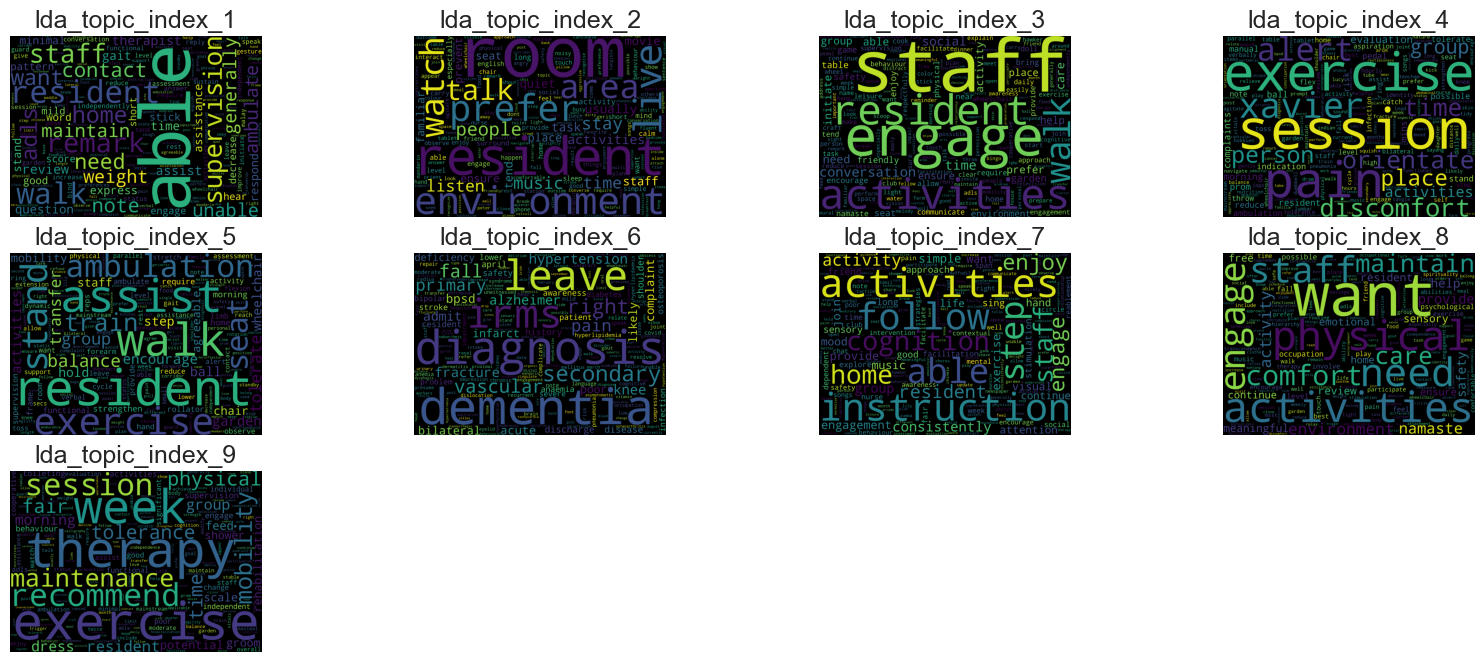

In [120]:
# identify the most frequent words in each topic
lda_model.get_topic_wordcloud(lda_model_predictions_df)

In [ ]:
# identify the most unique and differentiable words in each topic


In [77]:
# Assign aspects to topics 
ldaTopic_to_aspect = {
    0: [],
    1: ['service'],
    2: ['staff'],
    3: [],
    4: ['service', 'ambience'],
    5: ['menu'],
    6: ['price'],
    7: []
}

In [63]:
# the 9 topics identified from the living well plan
# topics = [
#     'MY UNIQUE EXPERIENCES',
#     'MY PREFERRED ENVIRONMENT - Physical',
#     'MY PREFERRED ENVIRONMENT - Social',
#     'MY PHYSICAL STRENGTHS',
#     'MY OCCUPATIONAL ABILITIES',
#     'MY PREFERRED ROUTINE',
#     'MY HEALTH - Physical',
#     'MY HEALTH - Mental',
#     'MY NEUROLOGICAL IMPAIRMENT'
# ]

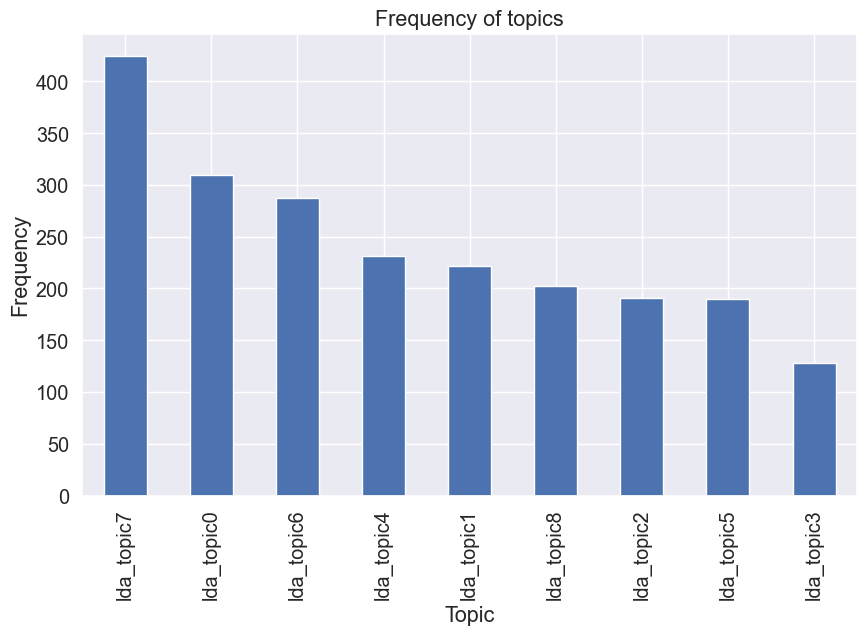

In [ ]:
# identify the distribution of topics
lda_model.get_topic_distribution(lda_model_predictions_df['predicted_topic'])

In [ ]:
# identify the most frequent words in each topic


In [ ]:
# identify the most salient words associated with each topic


## 2. NMF using Frobenius norm

In [15]:
# use vectorized reviews, X (using tf-idf)
nmf_fn = NMF(n_components=8, random_state=123)
reviews_topics = nmf_fn.fit_transform(X)

# Convert to dataframe
reviews_topics = pd.DataFrame(reviews_topics)
reviews_topics.columns = ['nmf_fn_topic' + str(col) for col in reviews_topics.columns]
print(reviews_topics.shape)
reviews_topics.head()

(3149, 8)


,nmf_fn_topic0,nmf_fn_topic1,nmf_fn_topic2,nmf_fn_topic3,nmf_fn_topic4,nmf_fn_topic5,nmf_fn_topic6,nmf_fn_topic7
0,0.054505,0.000595,0.003061,0.029524,0.047626,0.000000,0.000804,0.001468
1,0.000753,0.000000,0.000000,0.000000,0.000000,0.050649,0.059106,0.000000
2,0.000000,0.007693,0.004573,0.000000,0.013103,0.031692,0.057117,0.005431
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.010909,0.000000,0.169572
4,0.000000,0.007982,0.005254,0.005372,0.005943,0.012226,0.090415,0.007385


/Users/mahsa/opt/anaconda3/envs/NLP/lib/python3.7/site-packages/seaborn/matrix.py:302: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  mesh = ax.pcolormesh(self.plot_data, cmap=self.cmap, **kws)
/Users/mahsa/opt/anaconda3/envs/NLP/lib/python3.7/site-packages/seaborn/matrix.py:312: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = ax.figure.colorbar(mesh, cax, ax, **self.cbar_kws)


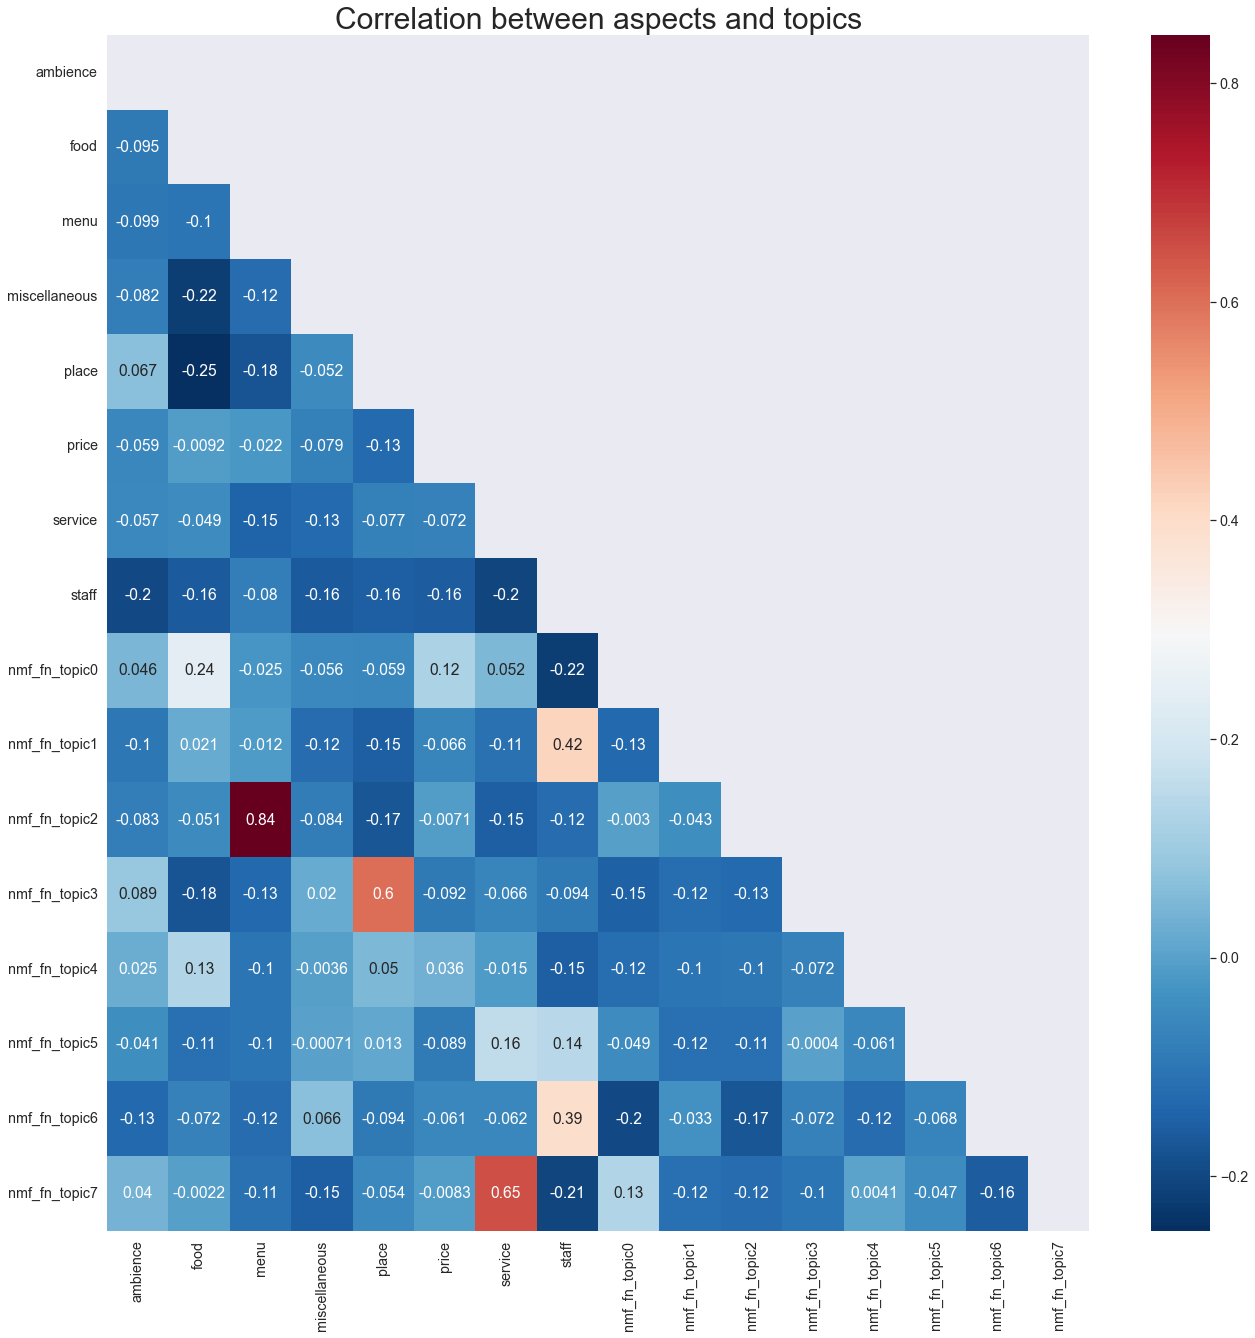

In [16]:
# Correlation between topics and aspects
topics_aspects = pd.concat([train.drop('review', axis=1), reviews_topics], axis=1)
topic_aspect_corplot(topics_aspects)

In [17]:
# Assign aspects to topics 
nmf_fnTopic_to_aspect = {
    0: [],
    1: ['staff'],
    2: ['menu'],
    3: ['place'],
    4: [],
    5: [],
    6: ['staff'], 
    7: ['service']
}

In [18]:
# Save the model
joblib.dump(nmf_fn, 'nmf_fn.pkl');

## 3. NMF using generalized Kullback-Leibler divergence

/Users/mahsa/opt/anaconda3/envs/NLP/lib/python3.7/site-packages/seaborn/matrix.py:302: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  mesh = ax.pcolormesh(self.plot_data, cmap=self.cmap, **kws)
/Users/mahsa/opt/anaconda3/envs/NLP/lib/python3.7/site-packages/seaborn/matrix.py:312: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = ax.figure.colorbar(mesh, cax, ax, **self.cbar_kws)


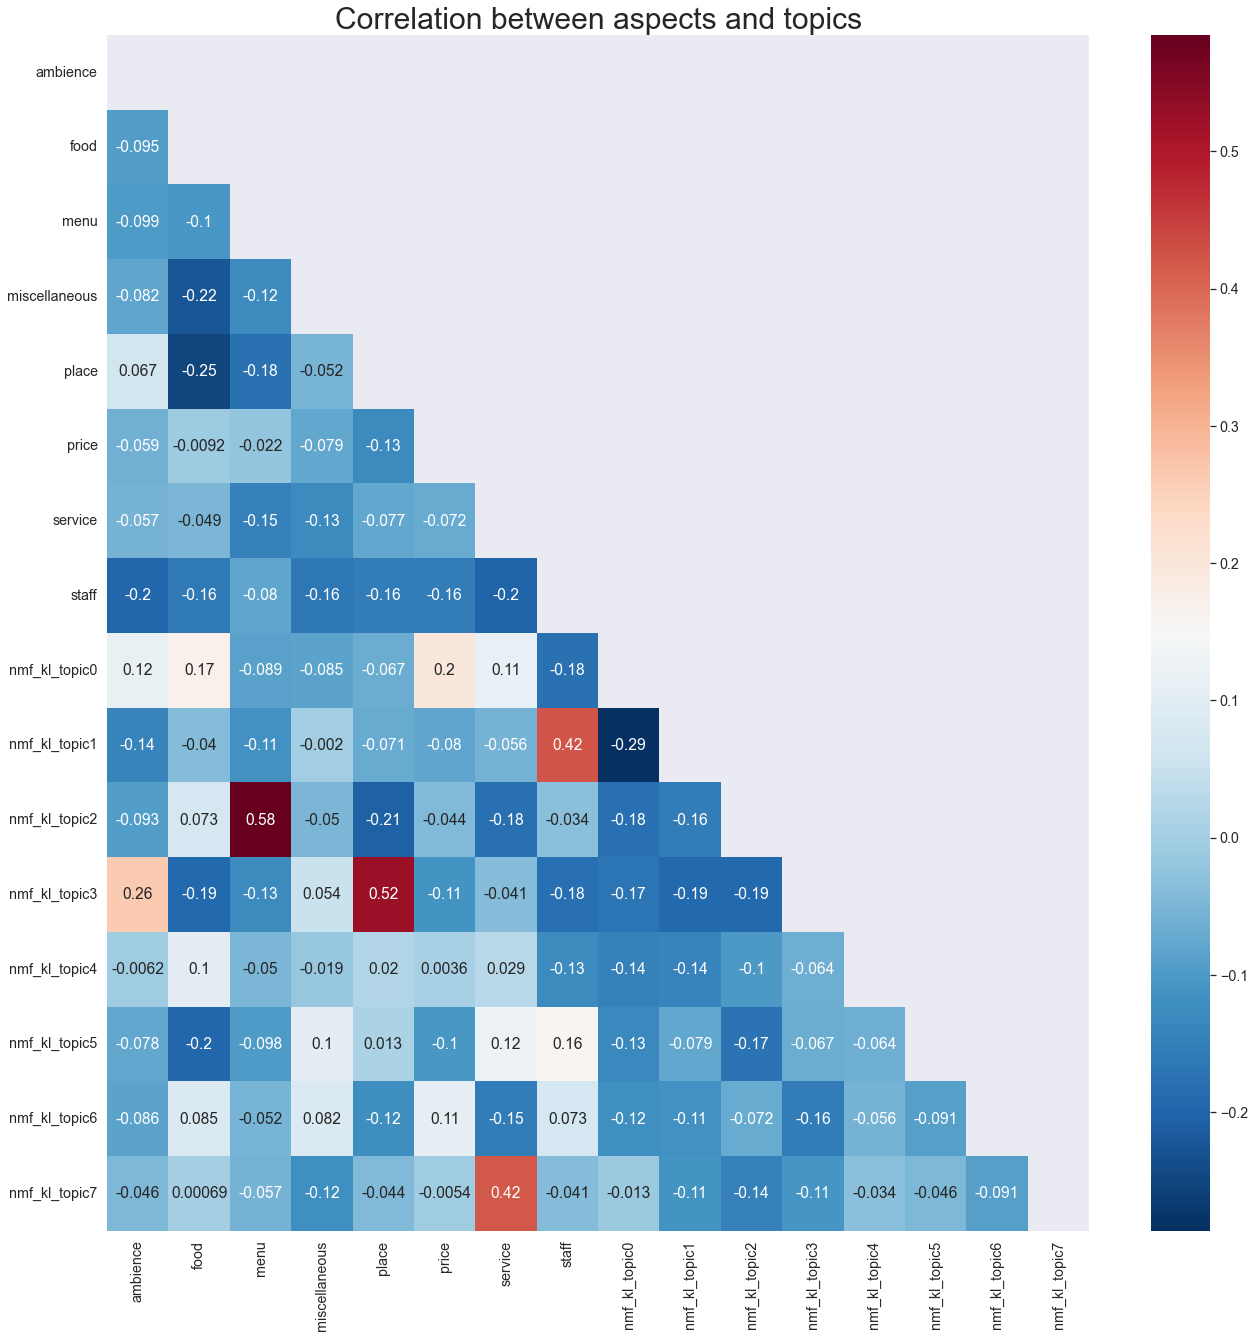

In [19]:
nmf_kl = NMF(n_components=8, random_state=123, beta_loss="kullback-leibler",
             solver="mu", max_iter=1000)

reviews_topics = nmf_kl.fit_transform(X)
reviews_topics = pd.DataFrame(reviews_topics)
reviews_topics.columns = ['nmf_kl_topic' + str(col) for col in reviews_topics.columns]

topics_aspects = pd.concat([train.drop('review', axis=1), reviews_topics], axis=1)
topic_aspect_corplot(topics_aspects)

In [20]:
# Assign aspects to topics 
nmf_klTopic_to_aspect = {
    0: ['price', 'food'],
    1: ['staff'],
    2: ['menu'],
    3: ['place', 'ambience'],
    4: [],
    5: [],
    6: [],
    7: ['service']
}

In [21]:
# Save the  model
joblib.dump(nmf_fn, 'nmf_kl.pkl');